# Capstone Project - The Battle of Neighborhoods

1. [Introduction](#intro)
2. [Data](#data)
3. [Setting Up Environment](#env)
4. [Web Scraping](#web)
5. [Getting Location Information](#loc)
6. [Getting Information on Food Venues](#food)
7. [Data Wrangling](#wrang)
8. [Scoring Venues and Neighborhoods](#score)

<a name="intro"></a>
## 1. Introduction

* In Singapore, a cosmopolitan city-state in Southeat Asia, food is central to the national identity and is an important cultural and social activity. Singaporeans are obsessed with eating, and take pride in the fact that Singapore is a gastronomic heaven with both delicious local cuisine and world-class international fares. Internationally, Singapore is also well-known for its food, especially its local hawker cuisine, and food is a major tourist attraction in the country. 
* This project seeks to use location data to determine the neighborhood in Singapore with the best food. This information has several useful applications for different target audiences:
    * Tourists who are foodies can find places to stay that will give them easy access to the best food, or find neighborhoods that they can visit for a one-stop food trial
    * Considering the importance of food nationally, Singaporeans can use the information as an additional metric when they are considering where to move and stay

<a name="data"></a>
## 2. Data
* The list of neighborhoods in Singapore can be obtained from this [Wikipedia page](https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore).
* The latitude and longitude coordinates of each neighborhood were collected manually from Google search.
* With this information, I use the Foursquare API to search for food venues near each of the neighborhoods, which gives me the following information:
    * ID
    * Name
    * Latitude
    * Longitude
    * Category
* For each of these food venues, I use the API to get further information on the location, namely:
    * Overall rating
    * Number of tips
    * Number of likes
* I score each neighborhood based on the number of food venues nearby, overall rating and popularity (measured by check-ins and tips) to determine the best neighborhood.

<a name="env"></a>
## 3. Setting Up Environment

In [1]:
# Libraries for data analysis
import pandas as pd
import numpy as np

# Libraries for web scraping
from urllib.request import urlopen
from bs4 import BeautifulSoup

# !pip install folium
import folium

import requests

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

<a name="web"></a>
## 4. Web Scraping
* I scraped this [Wikipedia page](https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore) for the list of neighborhoods in Singapore.
* I clean the data and retain only the relevant columns, namely: 'Neighborhood','Region' and 'Population'.
* I drop the rows where 'Population' is '*', as these districts with no residents are either industrial or natural parks with no food or housing options.

In [2]:
url = 'https://en.wikipedia.org/wiki/Planning_Areas_of_Singapore'
html = urlopen(url)

# Get rows of table as a list
soup = BeautifulSoup(html, 'lxml')
table = soup.find_all('table')[2]
table_rows = table.find_all('tr')

# Remove html tags and newlines and append to list
list_row = []
for tr in table_rows:
    td = tr.find_all('td')
    str_cells = str(td)
    str_cells = str_cells.replace('\n','',9)
    cleantext = BeautifulSoup(str_cells, "lxml").get_text()
    list_row.append(cleantext)
print(list_row[0:5])

['[]', '[Ang Mo Kio, , 宏茂桥, Hóng mào qiáo, ஆங் மோ கியோ, North-East, 13.94, 163,950, 13,400]', '[Bedok, *, 勿洛, Wù luò, பிடோக், East, 21.69, 279,380, 13,000]', '[Bishan, , 碧山, Bì shān, பீஷான், Central, 7.62, 88,010, 12,000]', '[Boon Lay, , 文礼, Wén lǐ, பூன் லே, West, 8.23, 30, 3.6]']


In [3]:
# Convert list to dataframe
df = pd.DataFrame(list_row)
df.head()

,0
0,[]
1,"[Ang Mo Kio, , 宏茂桥, Hóng mào qiáo, ஆங் மோ கியோ..."
2,"[Bedok, *, 勿洛, Wù luò, பிடோக், East, 21.69, 27..."
3,"[Bishan, , 碧山, Bì shān, பீஷான், Central, 7.62,..."
4,"[Boon Lay, , 文礼, Wén lǐ, பூன் லே, West, 8.23, ..."


In [4]:
# Remove irrelevant row
df.drop(0, inplace=True)
# Split column 0 into separate columns
df = df[0].str.split(', ', expand=True)
df[0] = df[0].str.strip('[')
df[7] = df[7].str.strip(']')
df.head()

,0,1,2,3,4,5,6,7,8
1,Ang Mo Kio,,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,"163,950","13,400]"
2,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,"279,380","13,000]"
3,Bishan,,碧山,Bì shān,பீஷான்,Central,7.62,"88,010","12,000]"
4,Boon Lay,,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6]
5,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,"153,740","14,000]"


In [5]:
# Get table header
col_labels = soup.find_all('th')[10:19]
all_header = []
col_str = str(col_labels)
col_str = col_str.replace('\n','',9)
cleantext2 = BeautifulSoup(col_str, "lxml").get_text()
all_header.append(cleantext2)
print(all_header)

['[Name (English), Malay, Chinese, Pinyin, Tamil, Region, Area (km2), Population[7], Density (/km2)]']


In [6]:
# Convert list to dataframe and split into multiple columns
df_header = pd.DataFrame(all_header)
df_header = df_header[0].str.split(', ', expand=True)
df_header

,0,1,2,3,4,5,6,7,8
0,[Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)]


In [7]:
# Concatenate dataframes together and change column names
df = pd.concat([df_header,df])
df = df.rename(columns=df.iloc[0])
df.drop(0, inplace=True)
df.head()

,[Name (English),Malay,Chinese,Pinyin,Tamil,Region,Area (km2),Population[7],Density (/km2)]
1,Ang Mo Kio,,宏茂桥,Hóng mào qiáo,ஆங் மோ கியோ,North-East,13.94,"163,950","13,400]"
2,Bedok,*,勿洛,Wù luò,பிடோக்,East,21.69,"279,380","13,000]"
3,Bishan,,碧山,Bì shān,பீஷான்,Central,7.62,"88,010","12,000]"
4,Boon Lay,,文礼,Wén lǐ,பூன் லே,West,8.23,30,3.6]
5,Bukit Batok,*,武吉巴督,Wǔjí bā dū,புக்கிட் பாத்தோக்,West,11.13,"153,740","14,000]"


In [8]:
df.rename(index=str,columns={'[Name (English)':'Neighborhood','Area (km2)':'Area','Population[7]':'Population','Density (/km2)]':'Density'}, inplace=True)
# Keep relevant columns
df = df[['Neighborhood','Region','Population']]

# Drop rows where population is *
df_pop = df['Population'] == '*'
df.drop(df.loc[df_pop].index, inplace = True)
df = df.reset_index(drop=True)

print(df.shape)
df.head()

(49, 3)


,Neighborhood,Region,Population
0,Ang Mo Kio,North-East,"163,950"
1,Bedok,East,"279,380"
2,Bishan,Central,"88,010"
3,Boon Lay,West,30
4,Bukit Batok,West,"153,740"


<a name="loc"></a>
## 5. Getting Location Information
* I had to collect the location information manually through searching Google, as the Google Maps Geocoding API did not work for me. I compiled the data in a CSV file hosted on my GitHub repository.

In [9]:
df_loc = pd.read_csv('https://raw.githubusercontent.com/jiantleman/Coursera_Capstone/master/data/Singapore_location_data.csv')
df_loc.head()

,Neighborhood,Latitude,Longitude
0,Ang Mo Kio,1.3691,103.8454
1,Bedok,1.3236,103.9273
2,Bishan,1.3526,103.8352
3,Boon Lay,1.3386,103.7058
4,Bukit Batok,1.3590,103.7637


In [10]:
df = pd.merge(df,df_loc,on='Neighborhood')
df.head()

,Neighborhood,Region,Population,Latitude,Longitude
0,Ang Mo Kio,North-East,"163,950",1.3691,103.8454
1,Bedok,East,"279,380",1.3236,103.9273
2,Bishan,Central,"88,010",1.3526,103.8352
3,Boon Lay,West,30,1.3386,103.7058
4,Bukit Batok,West,"153,740",1.3590,103.7637


<a name="food"></a>
## 6. Getting Information on Food Venues
* I used the Foursquare API to make a venue search with the search term 'food' to get the list of food places within each neighborhood. For each of these venues, I extracted the following details from the result:
    * ID
    * Name
    * Latitude
    * Longitude
    * Category
* I cleaned the data by removing results whose categories are not food-related.
* For each of these venues, I then used the Foursquare API get the details of the venue. I extracted the following details from the result:
    * Rating
    * Tip Count
    * Likes
* As quering the venue details is a premium function for which Foursquare has a quota, I collected in information in batches and saved the data in a CSV file for easy access.

In [11]:
CLIENT_ID = 'Y1UYRJPABZOC4MIDE21NJBWZPBIC5ZRJCP5RMUIKRA3ULAQ0'
CLIENT_SECRET = 'EFHE4LQN3W0OLCEGRSUF1JC2RUNI1ZCLC4RLDUJCLLKWIUST'
VERSION = '20200513'
LIMIT = 100
RADIUS = 500
QUERY = 'food'

print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

CLIENT_ID: Y1UYRJPABZOC4MIDE21NJBWZPBIC5ZRJCP5RMUIKRA3ULAQ0
CLIENT_SECRET:EFHE4LQN3W0OLCEGRSUF1JC2RUNI1ZCLC4RLDUJCLLKWIUST


In [12]:
def get_food_venues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            QUERY,
            RADIUS, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        
        # return only relevant information for each nearby venue
        for v in results:
            try:
                categories = v['categories'][0]['name']
            except:
                categories = ''
            
            venues_list.append([(
                name, 
                lat, 
                lng, 
                v['id'],
                v['name'], 
                v['location']['lat'], 
                v['location']['lng'],
                categories)])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category']
    
    return(nearby_venues)

In [13]:
food_venues = get_food_venues(names=df['Neighborhood'],
                              latitudes=df['Latitude'],
                              longitudes=df['Longitude']
                             )

Ang Mo Kio
Bedok
Bishan
Boon Lay
Bukit Batok
Bukit Merah
Bukit Panjang
Bukit Timah
Changi
Choa Chu Kang
Clementi
Downtown Core
Geylang
Hougang
Jurong East
Jurong West
Kallang
Lim Chu Kang
Mandai
Marine Parade
Museum
Newton
North-Eastern Islands
Novena
Orchard
Outram
Pasir Ris
Paya Lebar
Pioneer
Punggol
Queenstown
River Valley
Rochor
Seletar
Sembawang
Sengkang
Serangoon
Singapore River
Southern Islands
Sungei Kadut
Tampines
Tanglin
Tengah
Toa Payoh
Tuas
Western Islands
Western Water Catchment
Woodlands
Yishun


In [14]:
print(food_venues.shape)
print('There are {} uniques categories.'.format(len(food_venues['Category'].unique())))
df.to_csv('venue_list.csv')
food_venues.head()

(1010, 8)
There are 109 uniques categories.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court


In [15]:
# Look at the categories to remove irrelevant categories
food_venues['Category'].unique()

array(['Food Court', 'Coffee Shop', 'Dessert Shop', 'Cosmetics Shop',
       'Ice Cream Shop', 'American Restaurant', 'South Indian Restaurant',
       'Asian Restaurant', 'Diner', 'Cafeteria', 'Food Truck', 'Food',
       'Restaurant', '', 'Indian Restaurant',
       'Vegetarian / Vegan Restaurant', 'North Indian Restaurant',
       'Chinese Restaurant', 'Snack Place', 'Breakfast Spot',
       'Halal Restaurant', 'Malay Restaurant', 'Food Service',
       'Fast Food Restaurant', 'Seafood Restaurant', 'BBQ Joint',
       'Bakery', 'Thai Restaurant', 'Fish & Chips Shop', 'Noodle House',
       'Plaza', 'Farmers Market', 'Juice Bar', 'Korean Restaurant',
       'Dim Sum Restaurant', 'Gourmet Shop', 'Japanese Restaurant',
       'Modern European Restaurant', 'College Classroom',
       'Indonesian Restaurant', 'Parking', 'Taxi Stand',
       'Tibetan Restaurant', 'Food & Drink Shop', 'College Cafeteria',
       'Steakhouse', 'Residential Building (Apartment / Condo)',
       'Vietnamese R

In [16]:
# Drop rows with irrelevant categories and rows without a category
incorrect_categories = ['','Cosmetics Shop', 'Plaza', 'College Classroom', 'Parking', 'Taxi Stand', 'Residential Building (Apartment / Condo)', 'Library', 'Emergency Room',
                        'Office', 'Factory', 'Coworking Space', 'History Museum', 'Art & Crafts Store', 'Shopping Mall', 'Pet Store', 'Bus Station', 'Medical Lab',
                        'Event Space' , 'Department Store', 'College Lab','College Academic Building']
incorrect_row = food_venues[food_venues['Category'].isin(incorrect_categories)]
food_venues.drop(incorrect_row.index, inplace = True)
print(food_venues.shape)
food_venues.head()

(871, 8)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court


In [17]:
def get_venue_details(n_name, n_lat, n_long, v_id, v_name, v_lat, v_long, v_cat):
    venues_list=[]
    for n_name, n_lat, n_long, v_id, v_name, v_lat, v_long, v_cat in zip(n_name, n_lat, n_long, v_id, v_name, v_lat, v_long, v_cat):
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            v_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
        # make the GET request
        results = requests.get(url).json()["response"]['venue']
                        
        # return only relevant information for each nearby venue
        try:
            rating = results['rating']
        except:
            rating = 0
        try:
            tip = results['tips']['count']
        except:
            tip = 0    
        try:
            likes = results['likes']['count']
        except:
            likes = 0
        
        venues_list.append([(
                        n_name,
                            n_lat,
                            n_long,
                            v_id,
                            v_name,
                            v_lat,
                            v_long,
                            v_cat,
                            rating,
                            tip,
                            likes)])
                    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Category',
                  'Rating',
                  'Tip Count',
                  'Likes']
    return(nearby_venues)

In [18]:
food_rating = get_venue_details(n_name=food_venues[:1]['Neighborhood'],
                                n_lat=food_venues[:1]['Neighborhood Latitude'],
                                n_long=food_venues[:1]['Neighborhood Longitude'],
                                v_id=food_venues[:1]['ID'],
                                v_name=food_venues[:1]['Venue'],
                                v_lat=food_venues[:1]['Venue Latitude'],
                                v_long=food_venues[:1]['Venue Longitude'],
                                v_cat=food_venues[:1]['Category'])
food_rating

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,6.8,162,99


In [19]:
# This function allows me to export and save CSV files so I can avoid having to make repeated requests to the Foursquare API
from IPython.display import HTML
import base64   

def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
    csv = df.to_csv(index =False)
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

create_download_link(food_rating)

In [20]:
food_rating = pd.read_csv('https://raw.githubusercontent.com/jiantleman/Coursera_Capstone/master/data/food_rating.csv')
food_rating.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,6.8,162,99
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,5.7,16,11
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,4.9,30,5
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,5.5,14,2
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,5.7,82,56


<a name="wrang"></a>
## 7. Data Wrangling
* For venues without a rating, tip count or likes, I replace the 0 values with the mean values of other venues in the same category.
* I normalize the rating, tip count and likes values using simple feature scaling such that they range from 0 to 1.

In [21]:
# Find the number of rows without a rating, tip or count
food_rating = food_rating.replace(0,np.nan)
missing_data = food_rating.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  
food_rating.head(7)

Neighborhood
False    874
Name: Neighborhood, dtype: int64

Neighborhood Latitude
False    874
Name: Neighborhood Latitude, dtype: int64

Neighborhood Longitude
False    874
Name: Neighborhood Longitude, dtype: int64

ID
False    874
Name: ID, dtype: int64

Venue
False    874
Name: Venue, dtype: int64

Venue Latitude
False    874
Name: Venue Latitude, dtype: int64

Venue Longitude
False    874
Name: Venue Longitude, dtype: int64

Category
False    874
Name: Category, dtype: int64

Rating
True     688
False    186
Name: Rating, dtype: int64

Tip Count
True     462
False    412
Name: Tip Count, dtype: int64

Likes
True     513
False    361
Name: Likes, dtype: int64



,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,6.8,162.0,99.0
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,5.7,16.0,11.0
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,4.9,30.0,5.0
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,5.5,14.0,2.0
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,5.7,82.0,56.0
5,Ang Mo Kio,1.3691,103.8454,4eca676261af9e1433206595,Food Park,1.365588,103.848983,Coffee Shop,5.6,7.0,4.0
6,Ang Mo Kio,1.3691,103.8454,532d236111d2a43125ed6a8c,Food Paradise,1.369095,103.848038,Dessert Shop,NaN,NaN,NaN


In [22]:
# Replace missing values with the mean value of rows with the same category
for column in ('Rating', 'Likes', 'Tip Count'):
    has_val = food_rating[column].notnull()
    mean = food_rating[has_val].groupby('Category')[column].mean()
    food_rating.loc[~has_val, column] = food_rating['Category'].map(mean)


food_rating.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,6.8,162.0,99.0
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,5.7,16.0,11.0
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,4.9,30.0,5.0
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,5.5,14.0,2.0
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,5.7,82.0,56.0
5,Ang Mo Kio,1.3691,103.8454,4eca676261af9e1433206595,Food Park,1.365588,103.848983,Coffee Shop,5.6,7.0,4.0
6,Ang Mo Kio,1.3691,103.8454,532d236111d2a43125ed6a8c,Food Paradise,1.369095,103.848038,Dessert Shop,NaN,1.5,2.0


In [23]:
# Check that the number of missing values have gone down
missing_data = food_rating.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("")  

Neighborhood
False    874
Name: Neighborhood, dtype: int64

Neighborhood Latitude
False    874
Name: Neighborhood Latitude, dtype: int64

Neighborhood Longitude
False    874
Name: Neighborhood Longitude, dtype: int64

ID
False    874
Name: ID, dtype: int64

Venue
False    874
Name: Venue, dtype: int64

Venue Latitude
False    874
Name: Venue Latitude, dtype: int64

Venue Longitude
False    874
Name: Venue Longitude, dtype: int64

Category
False    874
Name: Category, dtype: int64

Rating
False    694
True     180
Name: Rating, dtype: int64

Tip Count
False    841
True      33
Name: Tip Count, dtype: int64

Likes
False    831
True      43
Name: Likes, dtype: int64



In [24]:
# Change the NaN back to 0
food_rating = food_rating.replace(np.nan,0)
food_rating.head(7)

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,6.8,162.0,99.0
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,5.7,16.0,11.0
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,4.9,30.0,5.0
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,5.5,14.0,2.0
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,5.7,82.0,56.0
5,Ang Mo Kio,1.3691,103.8454,4eca676261af9e1433206595,Food Park,1.365588,103.848983,Coffee Shop,5.6,7.0,4.0
6,Ang Mo Kio,1.3691,103.8454,532d236111d2a43125ed6a8c,Food Paradise,1.369095,103.848038,Dessert Shop,0.0,1.5,2.0


In [25]:
# Normalize the rating, tip count and likes

food_rating['Rating'] = food_rating['Rating']/food_rating['Rating'].max()
food_rating['Tip Count'] = food_rating['Tip Count']/food_rating['Tip Count'].max()
food_rating['Likes'] = food_rating['Likes']/food_rating['Likes'].max()
food_rating.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,0.764045,0.364865,0.107492
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,0.640449,0.036036,0.011944
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,0.550562,0.067568,0.005429
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,0.617978,0.031532,0.002172
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,0.640449,0.184685,0.060803


<a name="score"></a>
## 8. Scoring Venues and Neighborhoods
* I give each venue a 'Makan' score (makan is the Malay word for eating, as well as a commonly used word in the local English creole Singlish).
    * The Makan score is tabulated using the following formula: rating + (tip count * like) * 1/4.
        * Given that most of tip counts and likes are closer to zero, the formula reduces the extent of the penalty for venues that have no tips or likes. 
        * After experimenting with various formulae, the above formula gives a reasonably good outcome with a decent spread in the scores and few outliers.
        * Venues with a high number of tips and likes (i.e. close to normalized value of 1), will get up to a maximum 50% boost on their overall score.
    * I normalize the scores to get a 'Makan' score out of 10.
* I then calculate the aggregate 'Makan' score for each neighborhood, and determine their ranking.

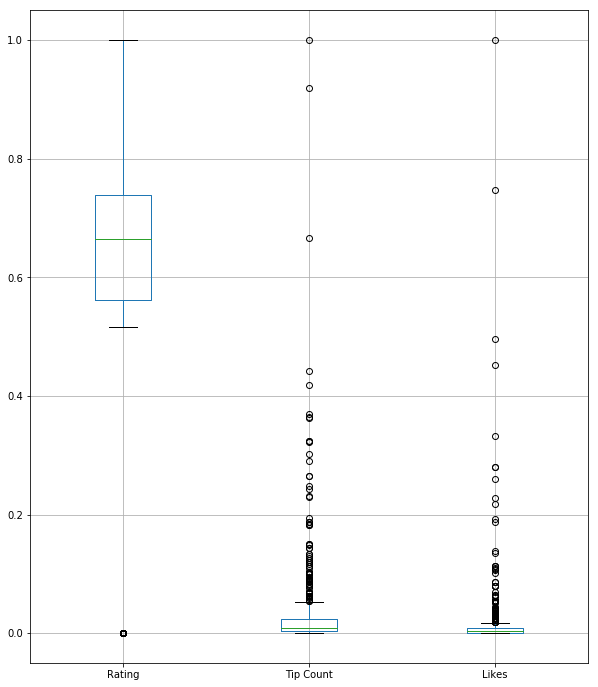

In [26]:
food_rating.boxplot(column = ['Rating','Tip Count','Likes'], figsize = (10,12))

In [27]:
# Calculate the Makan score for each venue
food_rating['Makan'] = food_rating['Rating'] + (food_rating['Tip Count'] * food_rating['Likes']) * 1/4
# Normalize the score to between 0 and 10
food_rating['Makan'] = (food_rating['Makan']/food_rating['Makan'].max()) * 10
food_rating.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,ID,Venue,Venue Latitude,Venue Longitude,Category,Rating,Tip Count,Likes,Makan
0,Ang Mo Kio,1.3691,103.8454,4c657dabe2ee9c749ce32d2f,Ang Mo Kio Central Market & Food Centre,1.372037,103.846366,Food Court,0.764045,0.364865,0.107492,6.606489
1,Ang Mo Kio,1.3691,103.8454,4d85cc1d509137042a3b9e5b,AMK 722 Food House,1.371989,103.847495,Food Court,0.640449,0.036036,0.011944,5.468544
2,Ang Mo Kio,1.3691,103.8454,4b691f1ff964a520ba992be3,Food Loft,1.372554,103.847913,Food Court,0.550562,0.067568,0.005429,4.701023
3,Ang Mo Kio,1.3691,103.8454,4bc08969b492d13a345ba460,AMK Food House,1.368245,103.844001,Coffee Shop,0.617978,0.031532,0.002172,5.275926
4,Ang Mo Kio,1.3691,103.8454,4b149e47f964a52023a523e3,S11 Food House,1.371501,103.847783,Food Court,0.640449,0.184685,0.060803,5.491593


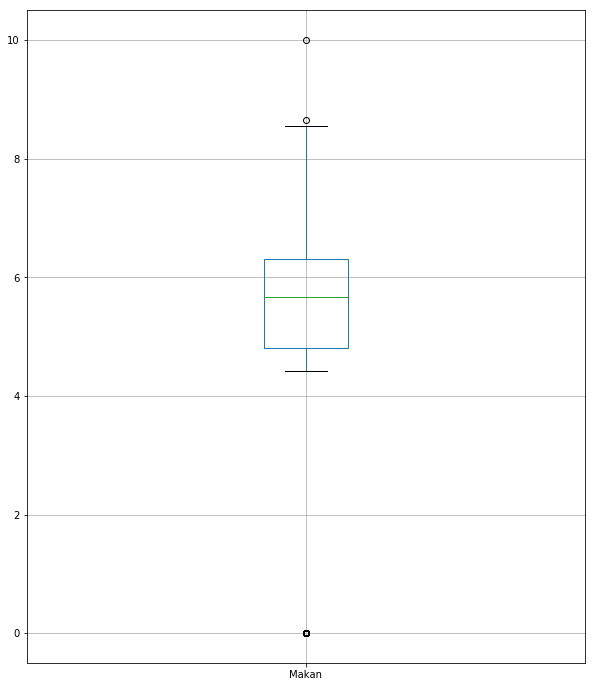

In [28]:
food_rating.boxplot(column = ['Makan'], figsize=(10,12))

In [29]:
# Sum the Makan scores of the venues in each neighborhood
neighborhood_rank = food_rating.groupby('Neighborhood').sum()
neighborhood_rank = neighborhood_rank[['Rating','Makan']]
neighborhood_rank = pd.merge(neighborhood_rank,df_loc,on='Neighborhood')
neighborhood_rank = neighborhood_rank[['Neighborhood','Latitude','Longitude','Makan']]

# # # Sort the values by their Makan scores
neighborhood_rank.sort_values('Makan', inplace=True, ascending=False)
neighborhood_rank.reset_index(inplace=True, drop=True)
neighborhood_rank.head(10)

,Neighborhood,Latitude,Longitude,Makan
0,Singapore River,1.2870,103.8500,233.632583
1,Outram,1.2849,103.8439,230.998949
2,Museum,1.2966,103.8485,219.333125
3,Rochor,1.3051,103.8509,218.745046
4,Orchard,1.3048,103.8318,212.049354
5,Bedok,1.3236,103.9273,198.531635
6,Bukit Merah,1.2819,103.8239,195.687392
7,Ang Mo Kio,1.3691,103.8454,186.343704
8,Toa Payoh,1.3343,103.8563,178.139644
9,Clementi,1.3162,103.7649,174.715102


In [30]:
NUM_NBH = 42

# create map
map_sin = folium.Map(location=[1.3521, 103.8198], zoom_start=12)

# set color scheme for the clusters
x = np.arange(NUM_NBH)
ys = [i + x + (i*x)**2 for i in range(NUM_NBH)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for index, name, lat, lon, makan in zip(neighborhood_rank.index, neighborhood_rank['Neighborhood'], neighborhood_rank['Latitude'],
                                        neighborhood_rank['Longitude'], neighborhood_rank['Makan']):
    label = folium.Popup(str(index+1)+'. '+name+' (Makan Score:'+str(int(makan))+')', parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[index],
        fill=True,
        fill_color=rainbow[index],
        fill_opacity=0.7).add_to(map_sin)
       
map_sin